35_metrics_roman_republic_133_27_bce Heatmap Generator

--- Diagnostic: Roman Republic (133–27 BCE) ---
X (Economic Metabolism): 0.380
Y (Governance Density): -0.053
Rule-13 Parasitism %: 18.6%
Dominant Attractor: Mixed (99.2%)
Zone: Separatrix
Estimated Longevity Window: 77–116 years (heuristic, open to testing)
Health Note: Balanced indicators — invites simulation stress-test


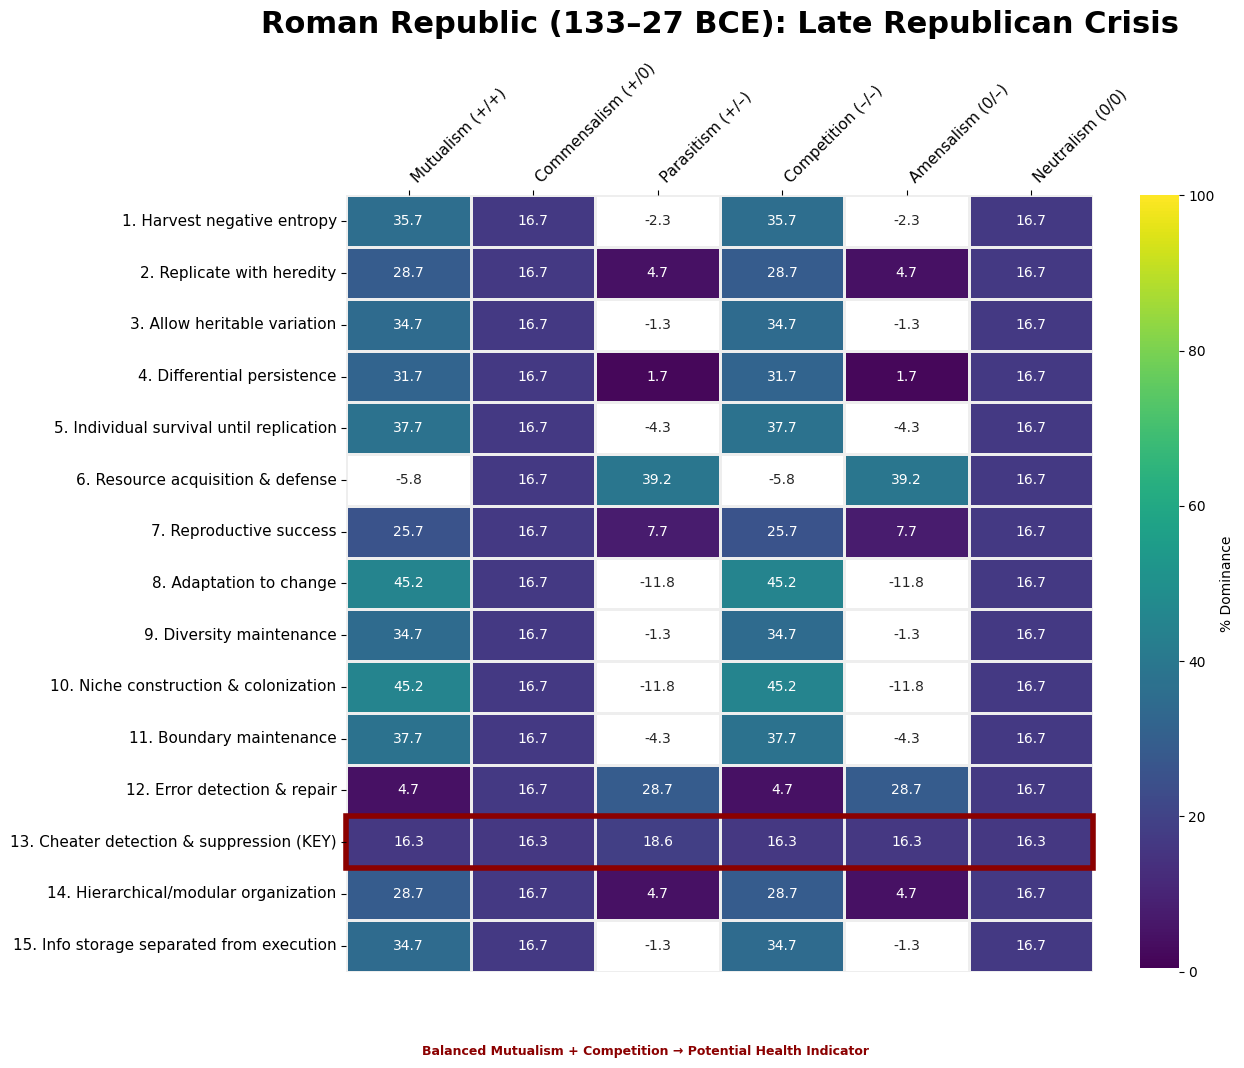

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# Load the CSV — use raw GitHub URL for direct fetch, or local path
# file_name = 'https://raw.githubusercontent.com/MementoMori15x6/15x6-sim/main/data/35_metrics_roman_republic_133_27_bce.csv'
file_name = '35_metrics_roman_republic_133_27_bce.csv'  # ← change to this if uploaded locally
df = pd.read_csv(file_name)
scores = df['Score'].to_numpy(dtype=float)
assert len(scores) == 35, "CSV must have exactly 35 scores."

# Apply non-linear penalty for extremes
def penalty(s):
    if abs(s) > 8:
        return s + np.sign(s) * (abs(s) - 8)**2 * 0.5
    return s
adjusted = np.array([penalty(s) for s in scores])

# Compute X (economic) and Y (governance)
economic = adjusted[0:18]
governance = adjusted[18:35]
mean_econ = np.mean(economic)
mean_gov = np.mean(governance)
X = mean_econ / 10 * 1.2
Y = mean_gov / 10 * 3.0

# Rigidity penalty (variation suppression × uniformity pressure)
c2_i123 = np.mean([adjusted[6], adjusted[20], adjusted[21], adjusted[22]])  # C2, I1-I3
variation_suppression = max(0, -c2_i123 / 10)
h123 = np.mean(adjusted[17:20])  # H1-H3
uniformity_pressure = max(0, h123 / 10)
rigidity = variation_suppression * uniformity_pressure
Y_adjusted = Y * (1 + 1.5 * rigidity)

# Clip to [-1, 1] phase space
X_clipped = np.clip(X, -1, 1)
Y_clipped = np.clip(Y_adjusted, -1, 1)

# Rule-13 parasitism % emphasis (negative-tilt metrics → suppression cost)
rule13_idx = [17, 18, 19, 20, 21, 22, 25]  # H1-H3, I1-I3, J3
rule13_values = adjusted[rule13_idx]
rule13_norm = rule13_values / 10
negative_mask = rule13_norm < 0
parasitism_weighted = np.sum(-rule13_norm[negative_mask]) / len(rule13_norm) if np.any(negative_mask) else 0
parasitism_pct = parasitism_weighted * 100

# Zone heuristic & longevity string
if Y_clipped >= 0.8:
    zone = "Prime Mutualism (Saturated Success)"
    longevity_str = "Centuries (high-trust baseline)"
elif 0.3 <= Y_clipped < 0.8:
    zone = "Stressed Mutualism"
    longevity_str = "Decades (drift zone)"
elif -0.29 < Y_clipped < 0.3:
    zone = "Separatrix"
    longevity_str = "Years (critical instability)"
elif -0.99 <= Y_clipped < -0.29:
    zone = "Active Competition"
    longevity_str = "Terminal (slow collapse)"
else:
    zone = "Boundary Saturation"
    longevity_str = "Imminent (kill switch active)"

# Splatter % to 10 attractors (inverse distance^10)
centers = [
    np.array([-1, -1]), np.array([-0.5, -1]), np.array([0, -1]), np.array([0.5, -1]),
    np.array([-1, 0]), np.array([0, 0]), np.array([1, 0]),
    np.array([-0.5, 1]), np.array([0.5, 1]), np.array([1, 1])
]
zone_names = ["Communism", "Fascism", "Authoritarian", "Auth Capital", "Socialism",
              "Mixed", "Capitalism", "Anarcho-left", "Libertarian", "Anarcho-cap"]
point = np.array([X_clipped, Y_clipped])
distances = [np.linalg.norm(point - c) for c in centers]
weights = [1 / d**10 if d != 0 else 1e10 for d in distances]  # avoid div0
total_w = sum(weights)
splatter = [w / total_w * 100 for w in weights]
dominant_idx = np.argmax(splatter)
dominant_zone = zone_names[dominant_idx]
dominant_pct = splatter[dominant_idx]

# 15×6 matrix construction from adjusted scores
rules = [
    "1. Harvest negative entropy", "2. Replicate with heredity", "3. Allow heritable variation",
    "4. Differential persistence", "5. Individual survival until replication", "6. Resource acquisition & defense",
    "7. Reproductive success", "8. Adaptation to change", "9. Diversity maintenance",
    "10. Niche construction & colonization", "11. Boundary maintenance", "12. Error detection & repair",
    "13. Cheater detection & suppression (KEY)", "14. Hierarchical/modular organization",
    "15. Info storage separated from execution"
]
moves = ["Mutualism (+/+)", "Commensalism (+/0)", "Parasitism (+/–)", "Competition (–/–)", "Amensalism (0/–)", "Neutralism (0/0)"]
rule_metrics_map = [
    [0,1,2], [5], [6], [7], [10], [3,4], [32], [9], [6], [11], [12], [13], [8,14], [15], [16]
]
matrix = np.zeros((15, 6))
for i in range(15):
    mean_score = np.mean(adjusted[rule_metrics_map[i]])
    norm_score = mean_score / 10
    amount = abs(norm_score) * 30
    if norm_score > 0:
        delta = [amount, 0, -amount, amount, -amount, 0]
    else:
        delta = [-amount, 0, amount, -amount, amount, 0]
    base = np.ones(6) * (100 / 6)
    row = base + delta
    row = row / np.sum(row) * 100
    matrix[i] = row
# Force Rule 13 parasitism column from computed %
matrix[12, 2] = parasitism_pct
remaining = 100 - parasitism_pct
matrix[12, [0,1,3,4,5]] = remaining / 5

# Heuristic longevity window
mutual_comp_avg = np.mean(matrix[:, [0,3]]) / 2
longevity = 100 / (1 + parasitism_pct / 100) * (1 + mutual_comp_avg / 100)
error = longevity * 0.2
longevity_window = f"{longevity - error:.0f}–{longevity + error:.0f} years (heuristic, open to testing)"

# Diagnostic printout
print("--- Diagnostic: Roman Republic (133–27 BCE) ---")
print(f"X (Economic Metabolism): {X_clipped:.3f}")
print(f"Y (Governance Density): {Y_clipped:.3f}")
print(f"Rule-13 Parasitism %: {parasitism_pct:.1f}%")
print(f"Dominant Attractor: {dominant_zone} ({dominant_pct:.1f}%)")
print(f"Zone: {zone}")
print(f"Estimated Longevity Window: {longevity_window}")
print(f"Health Note: {'Potential collapse indicator (Rule-13 >30%)' if parasitism_pct > 30 else 'Balanced indicators — invites simulation stress-test'}")

# Heatmap visualization
viridis_base = mpl.colormaps['viridis']
newcolors = viridis_base(np.linspace(0, 1, 256))
newcolors[0] = [1, 1, 1, 1]  # white for low values
custom_map = LinearSegmentedColormap.from_list('WhiteViridis', newcolors)
oxford_red = "#8B0000"
df_grid = pd.DataFrame(matrix, index=rules, columns=moves)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(df_grid, annot=True, fmt=".1f", cmap=custom_map, vmin=0, vmax=100,
            linewidths=1, linecolor="#eeeeee", cbar_kws={'label': '% Dominance', 'pad': 0.05}, ax=ax)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticklabels(moves, rotation=45, ha="left", fontsize=11)
ax.set_yticklabels(rules, rotation=0, fontsize=11)
ax.set_title("Roman Republic (133–27 BCE): Late Republican Crisis", fontsize=22, fontweight='bold', pad=20)
ax.add_patch(plt.Rectangle((0, 12), 6, 1, fill=False, edgecolor=oxford_red, lw=4, clip_on=False))
fig.text(0.5, -0.05, "Critical Rule 13: >30 % Parasitism → Potential Collapse Risk" if parasitism_pct > 30 else "Balanced Mutualism + Competition → Potential Health Indicator",
         fontsize=9, color=oxford_red, ha='center', va='top', fontweight='bold')
plt.tight_layout()
plt.savefig("roman_republic_133_27_bce_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()